In [1]:
import sys, time, timeit, cProfile, pstats, importlib, itertools

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib
%matplotlib notebook
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (40., 7.)
matplotlib.rcParams.update({'font.size': 22})

%load_ext autoreload
%autoreload 2

from Database import *
from Densities import *
from MultiIndex import *
from Surrogates import *
from Transport import *

import plotutil, randutil

query_gauss = """
select {}
  from surrogateevaldbo as evl
  join surrogatedbo as sur
    on evl.surrog_id = sur.id
  join gaussiandbo as tar 
    on sur.target_id = tar.id
   and sur.target = 'dyinggaussian'
  join {} as mul
    on sur.multis_id = mul.id
 where tar.dim = {}
"""

In [5]:
n_quad = 5
n = 4
x_quad, w_quad = np.polynomial.legendre.leggauss(n_quad)
x = np.concatenate([x_quad/n - 1 + (2*i+1)/n for i in range(n)])
w = np.concatenate([w_quad for i in range(n)])
print(x)
print(w)

[-0.97654496 -0.88461733 -0.75       -0.61538267 -0.52345504 -0.47654496
 -0.38461733 -0.25       -0.11538267 -0.02345504  0.02345504  0.11538267
  0.25        0.38461733  0.47654496  0.52345504  0.61538267  0.75
  0.88461733  0.97654496]
[0.23692689 0.47862867 0.56888889 0.47862867 0.23692689 0.23692689
 0.47862867 0.56888889 0.47862867 0.23692689 0.23692689 0.47862867
 0.56888889 0.47862867 0.23692689 0.23692689 0.47862867 0.56888889
 0.47862867 0.23692689]


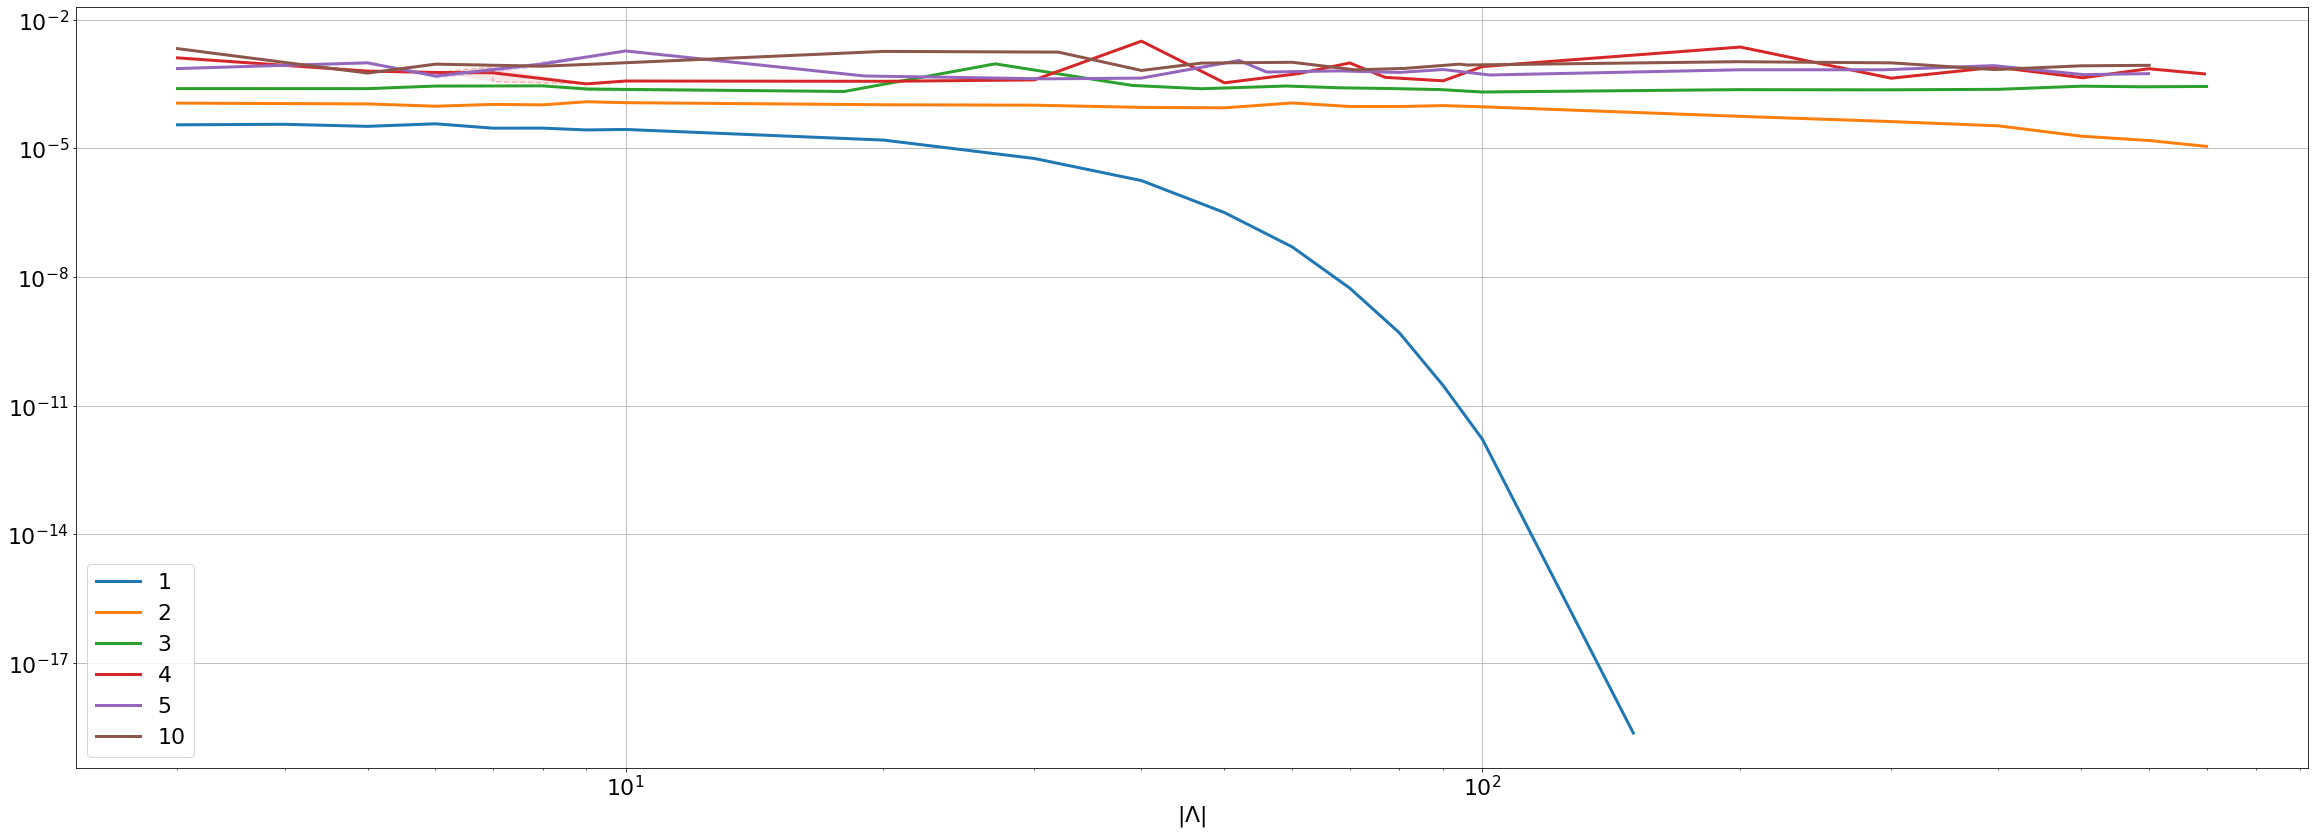

In [3]:
mins = {1 : 0, 2 : 0, 3 : 0, 4 : 0, 5 : 0, 10 : 0}
#mins = {1 : 2, 2 : 3, 3 : 4, 4 : 5, 5 : 6, 10 : 9}
dist = 'l2dist'

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax = plotutil.get_ax(plt.figure(figsize=(40., 14.)), 1, 1, xlabel=r'$|\Lambda|$', title='', logaxis=['x', 'y'])
for i, d in enumerate([1, 2, 3, 4, 5, 10]) :
    q = query_gauss.format('tar.id, mul.size, evl.'+dist, 'multiindexsetanisotropicdbo', d)
    cursor = DB.execute_sql(q)
    col_names = [col[0] for col in cursor.description] 
    res = sorted([dict(zip(col_names, row)) for row in cursor.fetchall()], key=lambda x : x['id'])
    res2 = dict()
    for k, g in itertools.groupby(res, lambda x : x['id']) :
        data = np.array([[r['size'], r[dist]] for r in sorted(g, key=lambda x :  x['size']) if r['size'] >= mins[d] and r[dist] is not None])
        #print(data[0,1])
        try :
            if len(data) > 0 :
                plt.plot(data[:, 0], data[:, 1], c=cycle[i], ls='dashed', alpha=.3)
        except IndexError :
            print(d, data)
        
        for da in data :
            if da[0] not in res2.keys() : res2[da[0]] = [da[1]]
            else : res2[da[0]].append(da[1])
    
    #maxlen = max([len(res2[k]) for k in res2.keys()])
    keys = [k for k in sorted(res2.keys())]#if len(res2[k]) == maxlen]
    #print(d, keys,  [len(res2[k]) for k in res2.keys()])
    mean = [np.mean(res2[k]) for k in keys]
    minm = [np.min(res2[k]) for k in keys]
    maxm = [np.max(res2[k]) for k in keys]
    ax.plot(keys, mean, c=cycle[i], lw=3, label=str(d))
    ax.fill_between(keys, minm, maxm, alpha=.1)
    
x = np.array([i*base for base in [1, 10, 100] for i in range(1,10)], dtype=float)
#ax.plot(x[1:9], 1e4*x[1:9]**(-13), 'k--')
#ax.plot(x[5:13], 1e4*x[5:13]**(-7), 'k--')
#ax.plot(x[7:20], 2e4*x[7:20]**(-5.5), 'k--')
ax.legend()
plt.show()

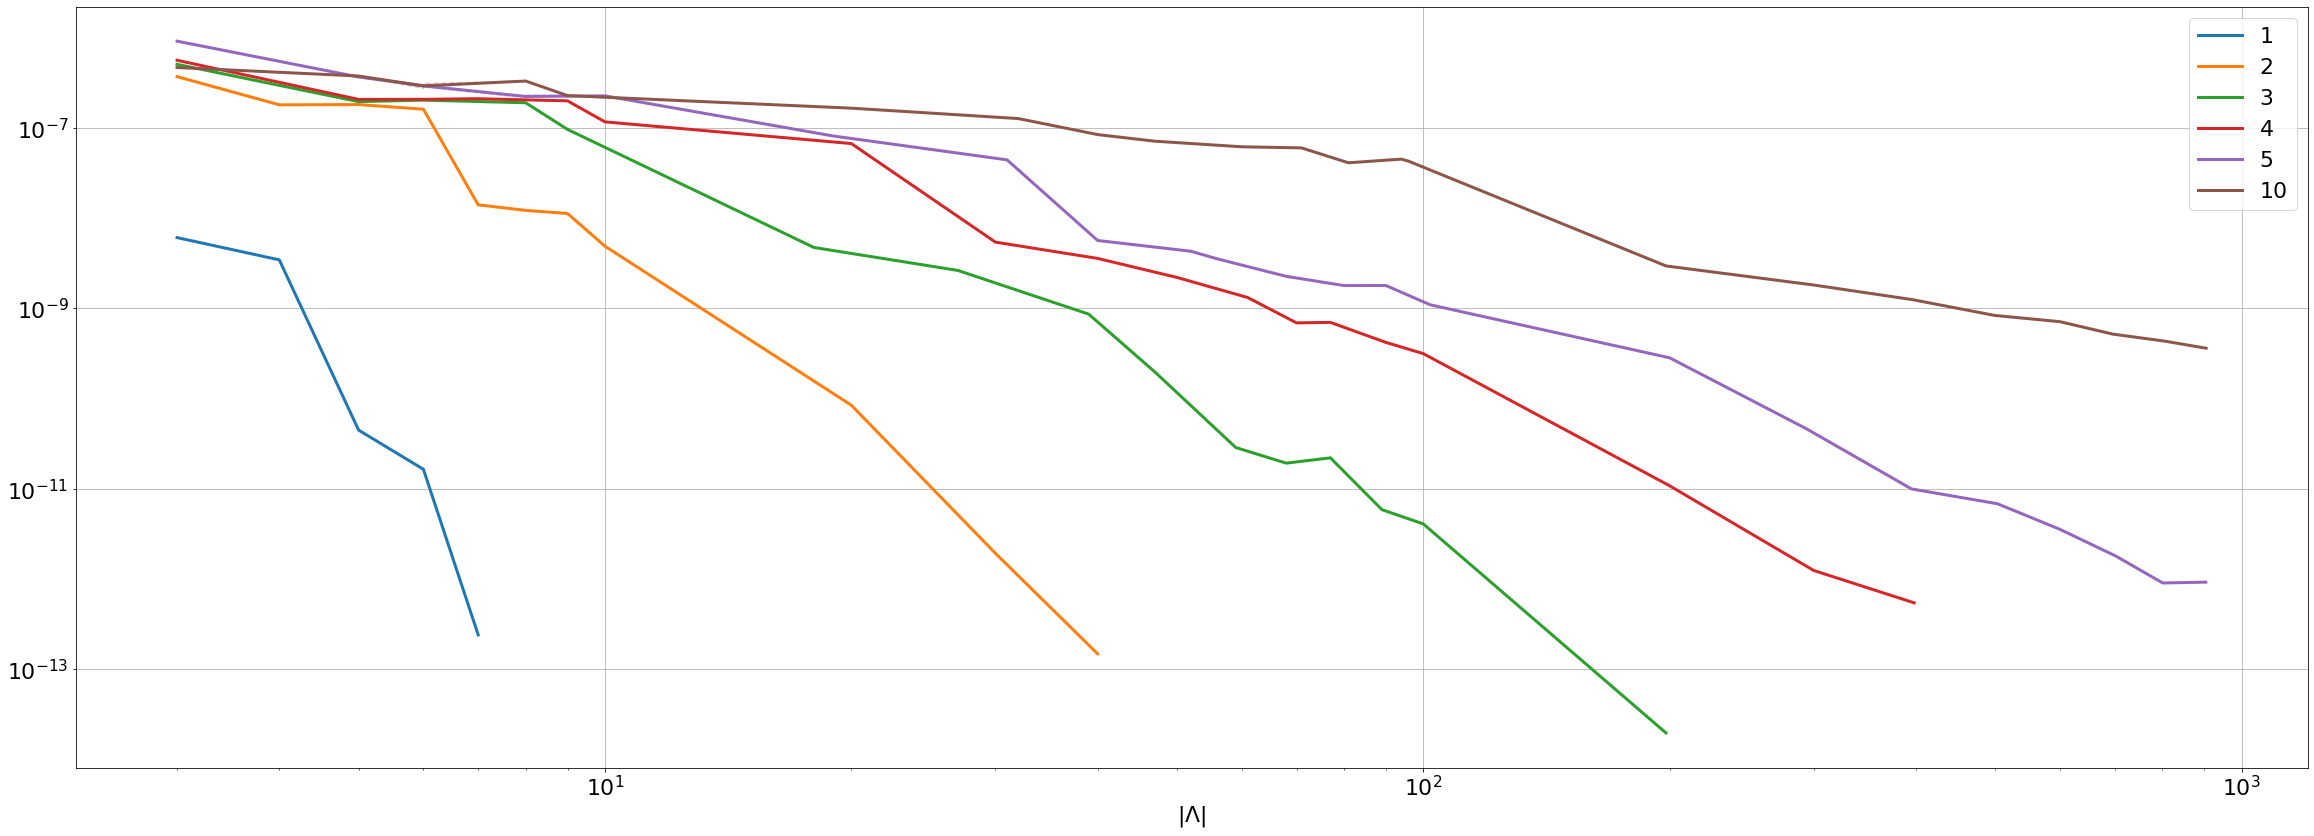

In [2]:
mins = {1 : 0, 2 : 0, 3 : 0, 4 : 0, 5 : 0, 10 : 0}
#mins = {1 : 2, 2 : 3, 3 : 4, 4 : 5, 5 : 6, 10 : 9}
dist = 'l2dist'

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax = plotutil.get_ax(plt.figure(figsize=(40., 14.)), 1, 1, xlabel=r'$|\Lambda|$', title='', logaxis=['x', 'y'])
for i, d in enumerate([1, 2, 3, 4, 5, 10]) :
    q = query_gauss.format('tar.id, mul.size, evl.'+dist, 'multiindexsetanisotropicdbo', d)
    cursor = DB.execute_sql(q)
    col_names = [col[0] for col in cursor.description] 
    res = sorted([dict(zip(col_names, row)) for row in cursor.fetchall()], key=lambda x : x['id'])
    res2 = dict()
    for k, g in itertools.groupby(res, lambda x : x['id']) :
        data = np.array([[r['size'], r[dist]] for r in sorted(g, key=lambda x :  x['size']) if r['size'] >= mins[d] and r[dist] is not None])
        #print(data[0,1])
        try :
            if len(data) > 0 :
                plt.plot(data[:, 0], data[:, 1], c=cycle[i], ls='dashed', alpha=.3)
        except IndexError :
            print(d, data)
        
        for da in data :
            if da[0] not in res2.keys() : res2[da[0]] = [da[1]]
            else : res2[da[0]].append(da[1])
    
    #maxlen = max([len(res2[k]) for k in res2.keys()])
    keys = [k for k in sorted(res2.keys())]#if len(res2[k]) == maxlen]
    #print(d, keys,  [len(res2[k]) for k in res2.keys()])
    mean = [np.mean(res2[k]) for k in keys]
    minm = [np.min(res2[k]) for k in keys]
    maxm = [np.max(res2[k]) for k in keys]
    ax.plot(keys, mean, c=cycle[i], lw=3, label=str(d))
    ax.fill_between(keys, minm, maxm, alpha=.1)
    
x = np.array([i*base for base in [1, 10, 100] for i in range(1,10)], dtype=float)
#ax.plot(x[1:9], 1e4*x[1:9]**(-13), 'k--')
#ax.plot(x[5:13], 1e4*x[5:13]**(-7), 'k--')
#ax.plot(x[7:20], 2e4*x[7:20]**(-5.5), 'k--')
ax.legend()
plt.show()

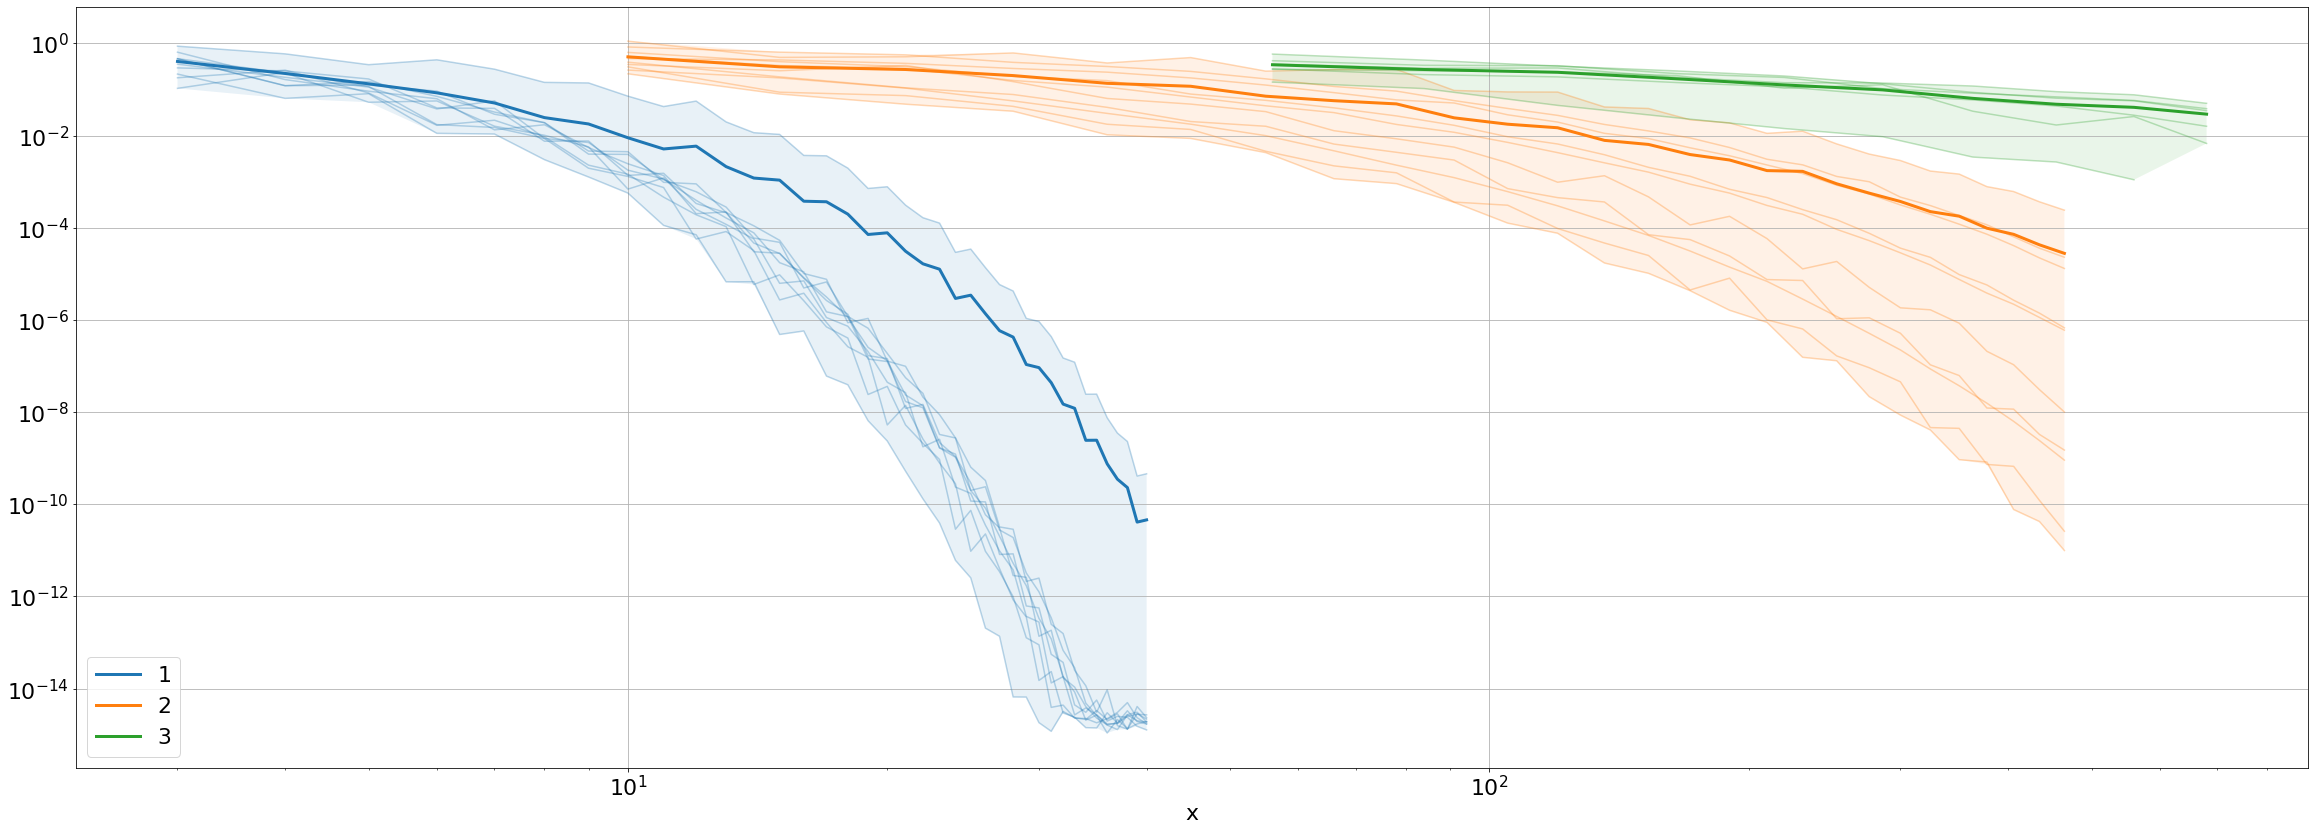

In [3]:
query = query_gauss.format('tar.id, mul.size, evl.l2dist', 'multiindexsetdbo'


mins = {1 : 0, 2 : 10, 3 : 50, 4 : 0}

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax = plotutil.get_ax(plt.figure(figsize=(40., 14.)), 1, 1, logaxis=['x', 'y'])
for i, d in enumerate([1,2,3]) :
    cursor = DB.execute_sql(query.format(d))
    col_names = [col[0] for col in cursor.description] 
    res = sorted([dict(zip(col_names, row)) for row in cursor.fetchall()], key=lambda x : x['id'])
    res2 = dict()
    for k, g in itertools.groupby(res, lambda x : x['id']) :
        data = np.array([[r['size'], r['l2dist']] for r in sorted(g, key=lambda x :  x['size']) if r['size'] >= mins[d] and r['l2dist'] is not None])
        try :
            if len(data) > 0 :
                ax.plot(data[:, 0], data[:, 1], c=cycle[i], alpha=.3)
        except IndexError :
            print(d, data)
        
        for da in data :
            if da[0] not in res2.keys() : res2[da[0]] = [da[1]]
            else : res2[da[0]].append(da[1])
    
    mean = [np.mean(res2[k]) for k in res2.keys()]
    minm = [np.min(res2[k]) for k in res2.keys()]
    maxm = [np.max(res2[k]) for k in res2.keys()]
    ax.plot(res2.keys(), mean, c=cycle[i], lw=3, label=str(d))
    ax.fill_between(res2.keys(), minm, maxm, alpha=.1)
    
ax.legend()
plt.show()

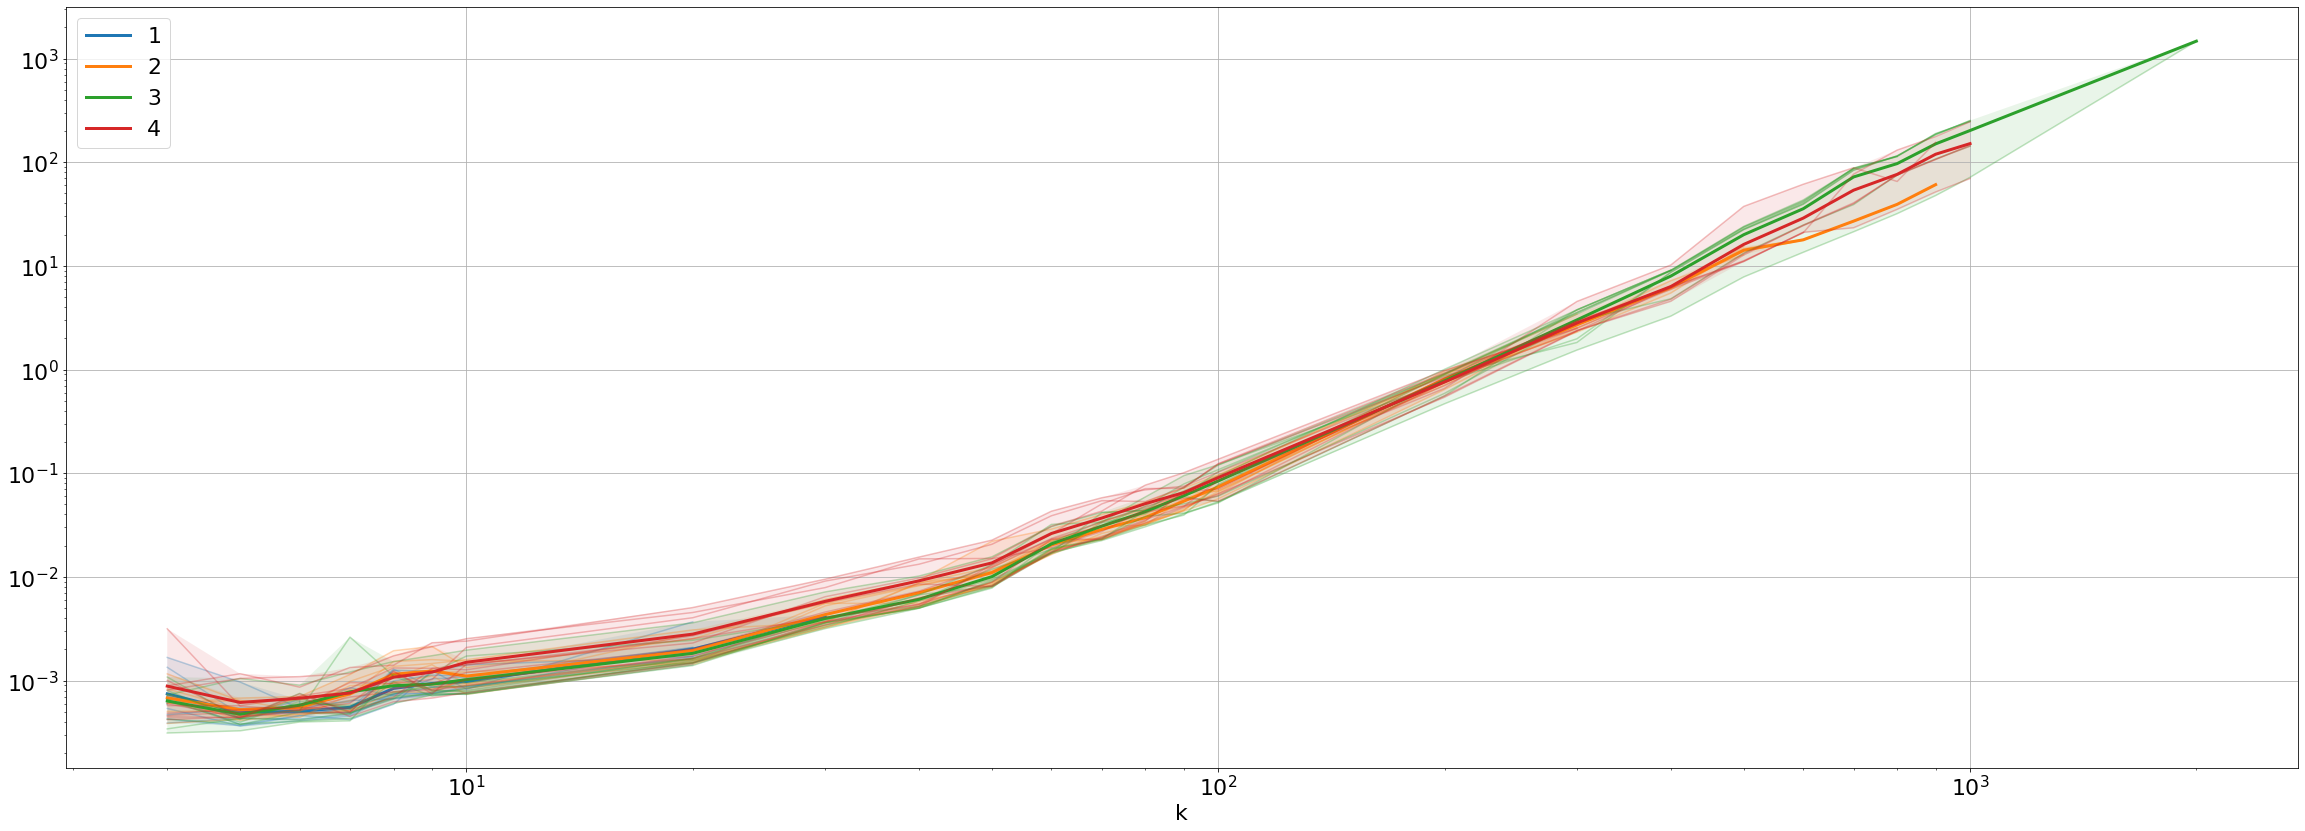

In [4]:
query = """
select gau.id, mul.size, sur.ctime
  from surrogateevaldbo as evl
  join surrogatedbo as sur
    on evl.surrog_id = sur.id
  join gaussiandbo as gau 
    on sur.target_id = gau.id
  join multiindexsetanisotropicdbo as mul
    on sur.multis_id = mul.id
where gau.dim = {}
"""

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax = plotutil.get_ax(plt.figure(figsize=(40., 14.)), 1, 1, xlabel='k', logaxis=['x', 'y'])
for i, d in enumerate([1,2,3,4]) :
    cursor = DB.execute_sql(query.format(d))
    col_names = [col[0] for col in cursor.description] 
    res = sorted([dict(zip(col_names, row)) for row in cursor.fetchall()], key=lambda x : x['id'])
    res2 = dict()
    for k, g in itertools.groupby(res, lambda x : x['id']) :
        data = np.array([[r['size'], r['ctime']] for r in sorted(g, key=lambda x :  x['size'])])
        ax.plot(data[:, 0], data[:, 1], c=cycle[i], alpha=.3)
        
        for da in data :
            if da[0] not in res2.keys() : res2[da[0]] = [da[1]]
            else : res2[da[0]].append(da[1])
    
    mean = [np.mean(res2[k]) for k in sorted(res2.keys())]
    minm = [np.min(res2[k]) for k in sorted(res2.keys())]
    maxm = [np.max(res2[k]) for k in sorted(res2.keys())]
    ax.plot(sorted(res2.keys()), mean, c=cycle[i], lw=3, label=str(d))
    
    ax.fill_between(res2.keys(), minm, maxm, alpha=.1)
    
ax.legend()
plt.show()

# Gauss 1D

In [2]:
t = Gaussian(mean=[.0], cova=[[.01]])
m = TensorProductSet(dim=1, k=12)
s = Legendre(multis=m, target=t, method='wls')
r = TransportMap(s)

setup TensorProductSet
Surrogate... Done


In [3]:
p = randutil.points(1,500)
i = np.zeros(p.shape)
for j in range(p.shape[1]) :
    i[:,j] = r.inveval(p[:,j])

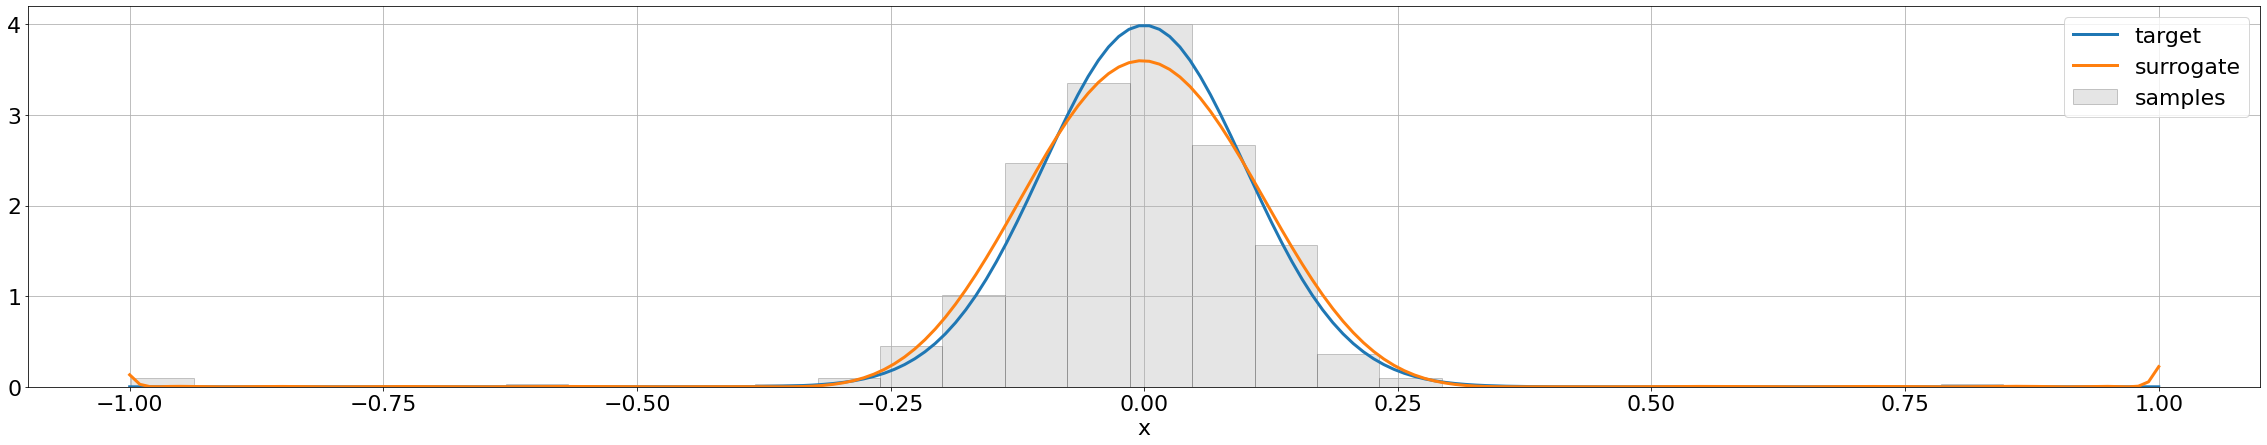

0.04814529413562303

In [5]:
x = np.linspace(-1,1,200)
ax = plotutil.get_ax(plt.figure(), 1, 1)
ax.plot(x, t.eval(x), lw=3, label='target')
ax.plot(x, s.eval(x), lw=3, label='surrogate')
ax.hist(i[0], bins=30, color='grey', ec='k', alpha=.2, label='samples', density=True)
ax.legend()
plt.show()
np.mean(np.abs(t.eval(x) - s.eval(x)))

In [16]:
x = np.linspace(-1,1,200)
sx = np.zeros(x.shape)
tx = np.zeros(x.shape)
xx = np.zeros(x.shape)
for i in range(200) :
    sx[i] = r.eval([x[i]])
    tx[i] = r.inveval([x[i]])[0]
    xx[i] = r.eval([tx[i]])

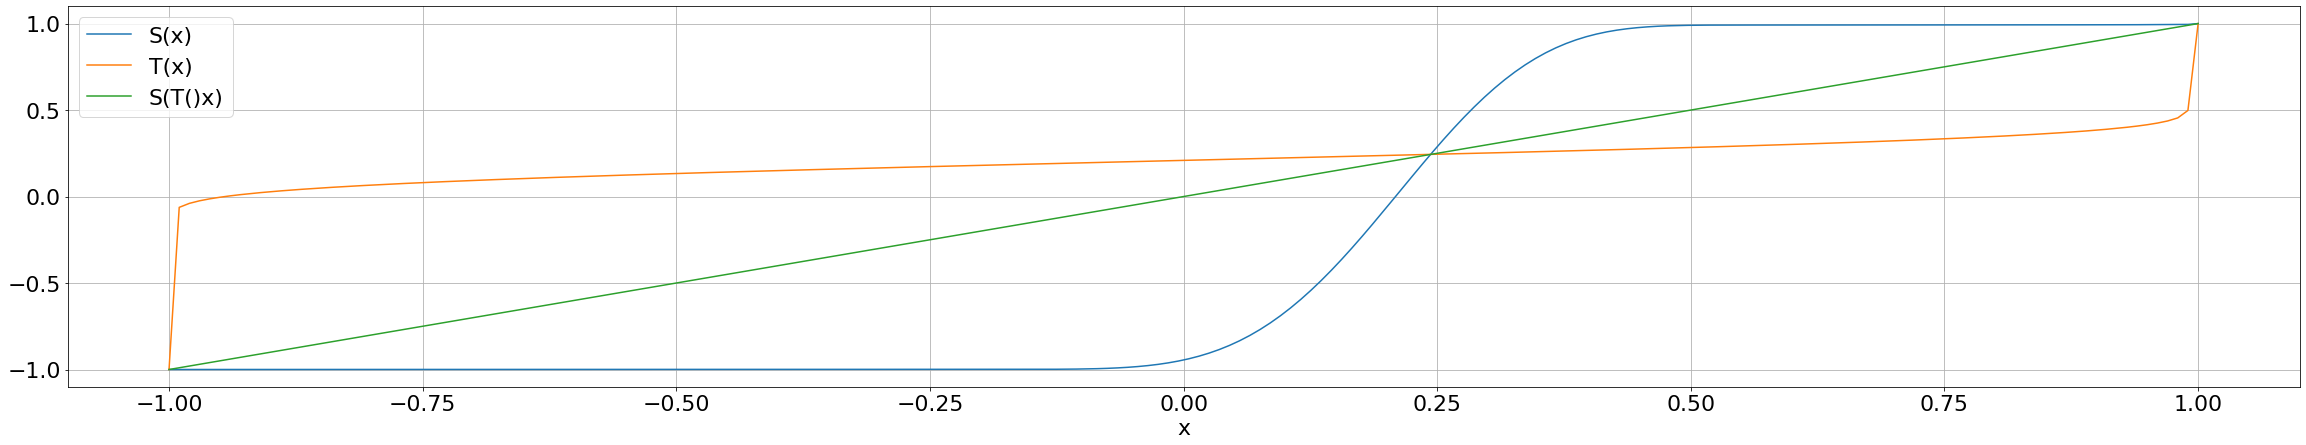

In [18]:
ax = plotutil.get_ax(plt.figure(), 1, 1)
ax.plot(x, sx, label='S(x)')
ax.plot(x, tx, label='T(x)')
ax.plot(x, xx, label='S(T()x)')
plt.legend()
plt.show()

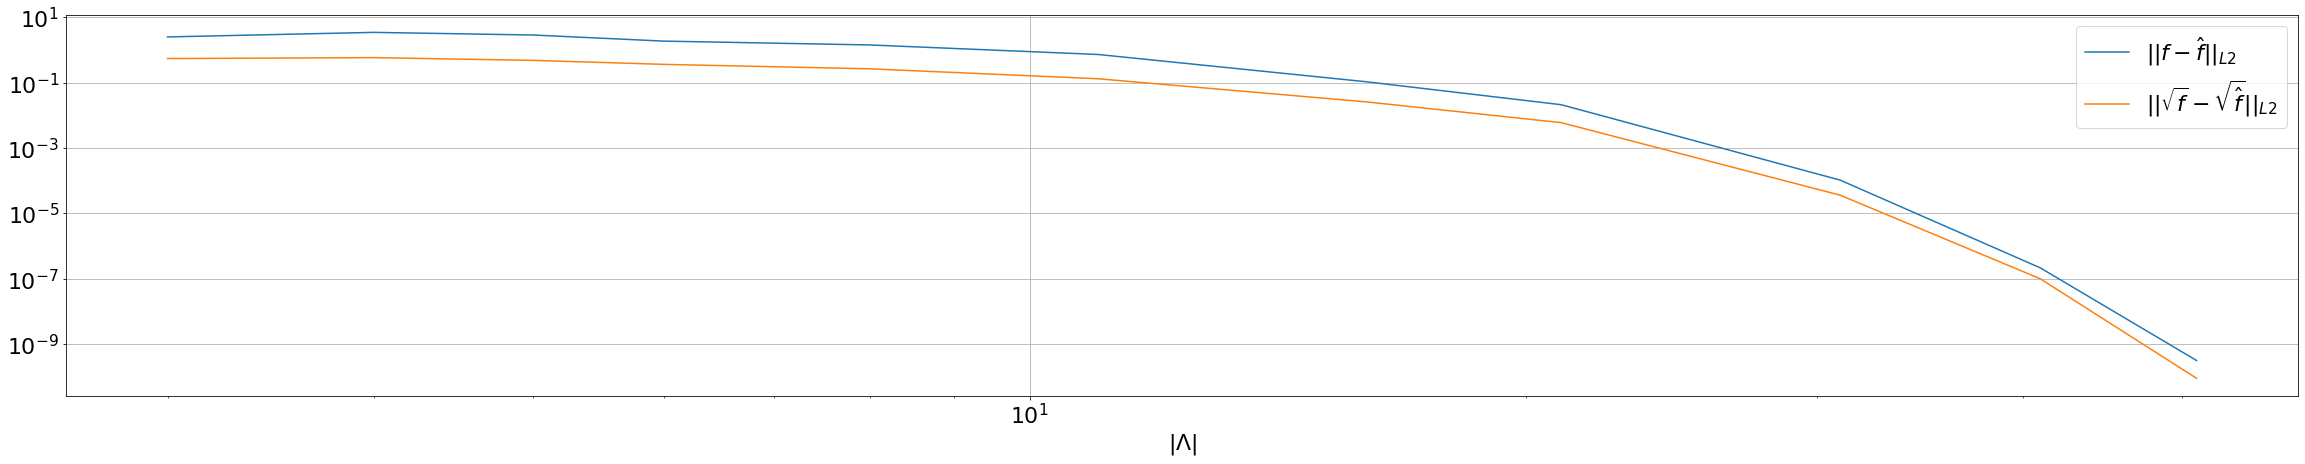

In [5]:
ax = plotutil.get_ax(plt.figure(), 1, 1, xlabel=r'$|\Lambda|$', logaxis=['x', 'y'])
ax.plot([r['m'].cardinality for r in rs], [r['e'].l2dist for r in rs], label=r'$||f - \hat{f}||_{L2}$')
ax.plot([r['m'].cardinality for r in rs], [r['e'].hedist for r in rs], label=r'$||\sqrt{f} - \sqrt{\hat{f}}||_{L2}$')
plt.legend()
plt.show()

# Gauss 2D

In [6]:
mean = np.array([[-0.82910471], [0.10852764]])
cova = np.array([[0.01714955, 0.0176695], [0.0176695, .02852501]])

t = Gaussian(mean=mean, cova=cova)
m = TotalDegreeSet(dim=2, k=15)
s = Legendre(multis=m, target=t, method='wls')

setup TotalDegreeSet
Surrogate... Done


In [7]:
t = Gaussian(mean=randutil.points(2,1), cova=randutil.covarm(2))
m = TotalDegreeSet(dim=2, k=21)
s = Legendre(multis=m, target=t, method='wls')
print(t.mean, '\n', t.cova)

setup TotalDegreeSet
Surrogate... Done
[[0.39949204]
 [0.98382661]] 
 [[0.01895392 0.00067971]
 [0.00067971 0.08201654]]


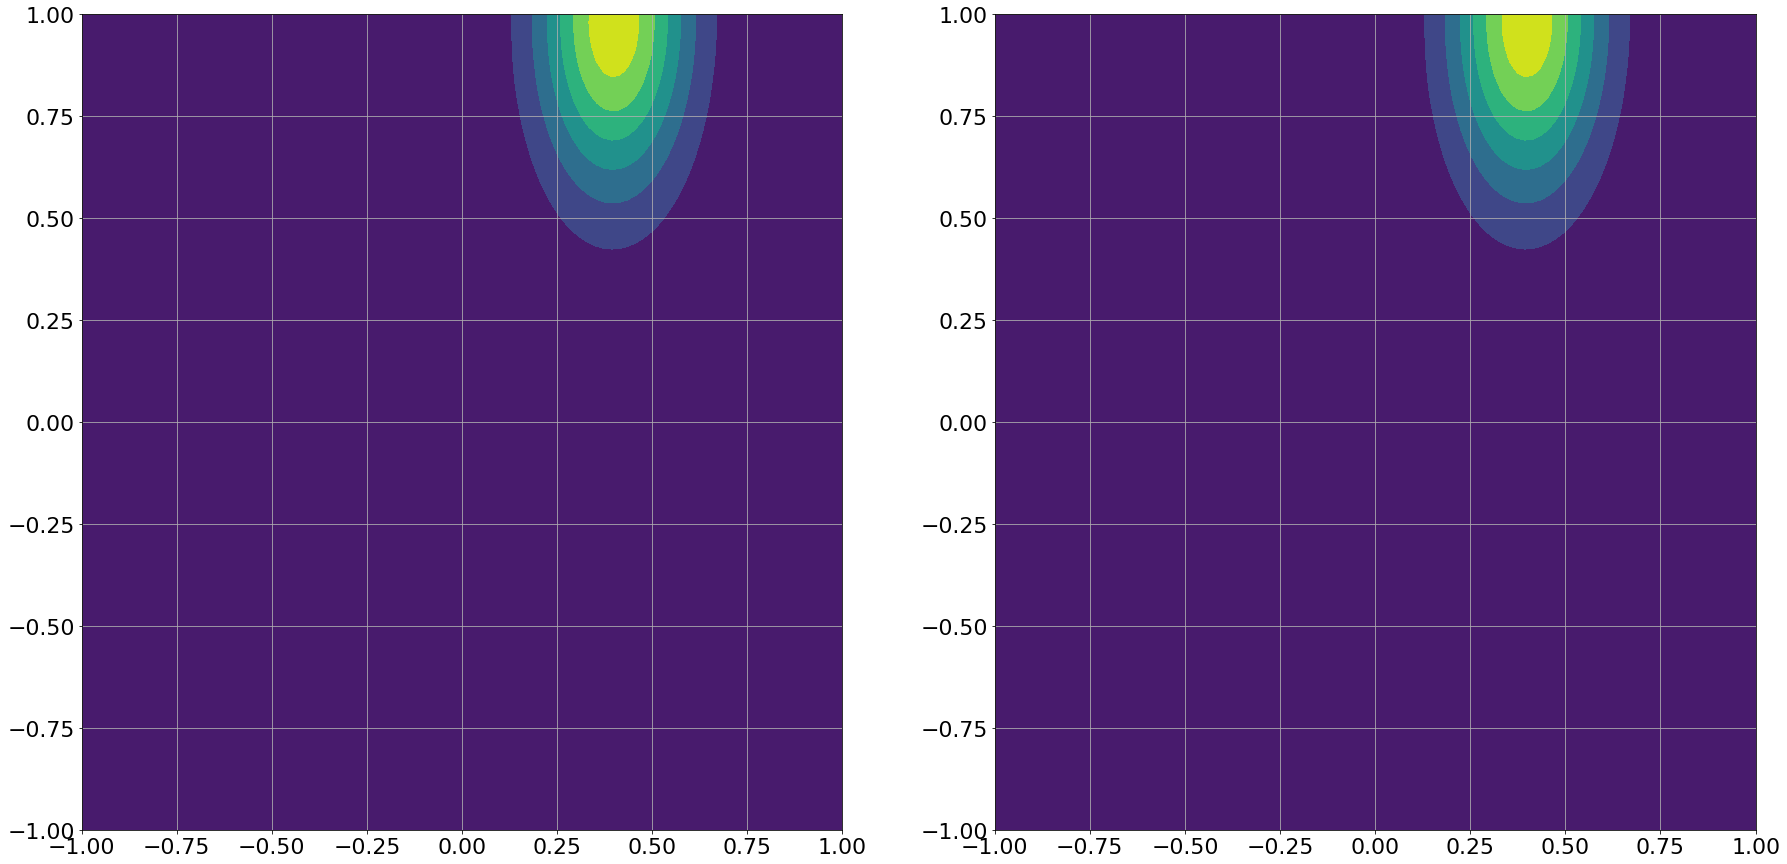

In [8]:
grid = np.mgrid[tuple(slice(-1, 1.1, .1) for _ in range(2))]
p_grid = np.vstack([grid[i].flatten() for i in range(2)])

x = np.linspace(-1,1,100)
X, Y = np.meshgrid(x, x)
pts = np.vstack((X.flatten(), Y.flatten()))

Ztar = t.eval(pts).reshape((len(x), len(x)))
Zsur = s.eval(pts).reshape((len(x), len(x)))


fig = plt.figure(figsize=(30,15))
ax = plotutil.get_ax(fig, 2, 1, xlabel='')
ax.contourf(X, Y, Ztar)
ax = plotutil.get_ax(fig, 2, 2, xlabel='')
ax.contourf(X, Y, Zsur)
plt.show()

In [11]:
s.eval([[-1,-1], [1,1]])

array([0.31307683, 0.31307683])

In [16]:
ms = [TotalDegreeSet(dim=2, k=k) for k in [2, 3, 4, 5, 7, 10, 15]]
rs1 = run(t, ms, 'wls', 'mc') 
rs2 = run(t, ms, 'wls_leggaus', 'mc') 
rs3 = run(t, ms, 'wls_leja', 'mc')

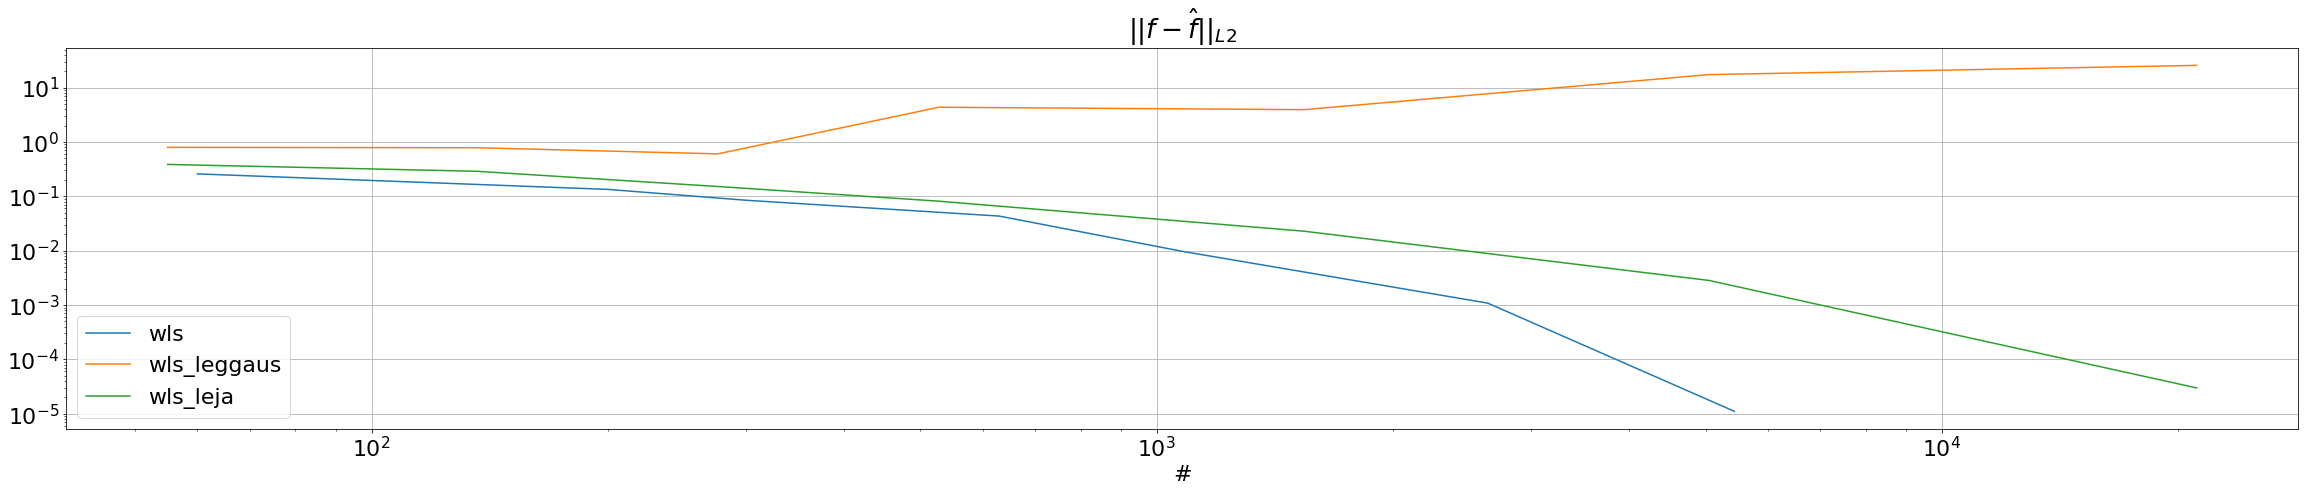

In [17]:
ax = plotutil.get_ax(plt.figure(), 1, 1, title=r'$||f - \hat{f}||_{L2}$', xlabel='#', logaxis=['x', 'y'])
ax.plot([r['s'].dbo.nevals for r in rs1], [r['e'].l2dist for r in rs1], label='wls')
ax.plot([r['s'].dbo.nevals for r in rs2], [r['e'].l2dist for r in rs2], label='wls_leggaus')
ax.plot([r['s'].dbo.nevals for r in rs3], [r['e'].l2dist for r in rs3], label='wls_leja')
plt.legend()
plt.show()

In [4]:
d = 1
t = DyingGaussian(mean=randutil.points(d,1))
m = SparseSet.withSize(weights=t.weights, n=3, t=4)
s = Legendre(multis=m, target=t, method='wls')
#e = SurrogateEvalDBO.get_or_create_from_args(t, s, 'mc', save=False)

In [59]:
nevals = 1000
points = np.random.uniform(low=-1, high=1, size=(t.dim, nevals))

evalsTar = t.eval(points)
evalsTar /= np.sum(evalsTar)
evalsSur = s.eval(points) #/ s.norm
evalsSur /= np.sum(evalsSur)

l2dist = np.sqrt(np.mean(evalsTar - evalsSur)**2)
hedist = np.sqrt(np.mean((np.sqrt(evalsTar) - np.sqrt(evalsSur))**2))

In [60]:
s.coeffs

array([ 0.61720302,  0.00877543, -0.01142245])

In [61]:
l2dist, hedist

(1.6707555478001623e-19, 1.0282164991980237e-05)

In [64]:
np.array([])

array([], dtype=float64)

In [36]:
np.sqrt((2*np.pi)**d * np.prod(t.weights**2)) *.5

0.31332853432887503

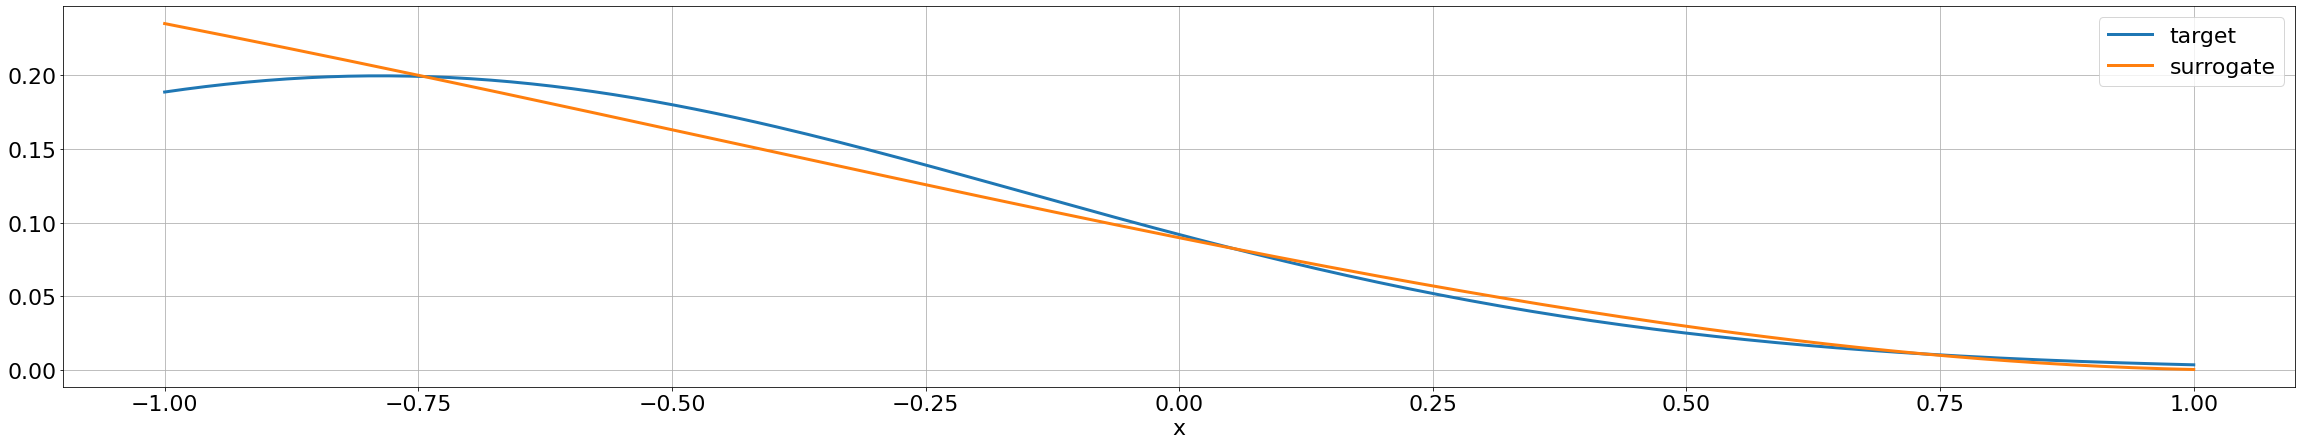

0.008633343694979624

In [5]:
x = np.linspace(-1,1,200)
ax = plotutil.get_ax(plt.figure(), 1, 1)
ax.plot(x, t.eval(x), lw=3, label='target')
ax.plot(x, s.eval(x), lw=3, label='surrogate')
ax.legend()
plt.show()
np.mean(np.abs(t.eval(x) - s.eval(x)))